In [1]:
import rtree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from descartes import PolygonPatch
from pysal.esda.mapclassify import K_classifiers, Fisher_Jenks
from shapely.geometry import Point, Polygon

In [2]:
%matplotlib inline

In [3]:
# Set ipython's max row display
pd.set_option('display.max_row', 10)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 200)

In [4]:
data = pd.read_csv('predictions.csv')

In [5]:
df_positive_ex = data[data['is_blighted'] == 1][['Latitude', 'Longitude']]

In [6]:
false_negatives = pd.read_csv('false_negatives.csv')

In [7]:
true_pos = pd.read_csv('true_positives.csv')

# Chloropleth

In [8]:
data['coordinates'] = list(zip(data['Longitude'], data['Latitude']))

In [9]:
data

,address,parcel_no,poly,sale_value,Latitude,Longitude,2YR NON-PROFIT HOUSE,BENEVOLENT/CHARITY,BOARD OF EDUCATION,CITY LAND BANK,CITY OWNED,COMMUNICATIONS,COUNTY LAND BANK,COUNTY OWNED,DETROIT HOUSING COMM,DISABLED VETERAN,EDUCATION/SCIENTIFIC,FEDERAL,HOSPITAL,NON-PROFIT,PA 245,PARSONAGE,PILOT,PROJECTS,PUBLIC LIGHTING,RAILROAD,REAL ESTATE DIVISION,RELIGIOUS,SEMTA,STATE LAND BANK,STATE OWNED,STATUTORY,TAXABLE,WATER DEPARTMENT,22-2-88(b),9-1-104,9-1-110(a),22-2-88(a),22-2-43,9-1-113,9-1-202,61-85.0100/32.0066,9-1-83 - (Structures < 5 stories),9-1-81(a),9-1-36(a),9-1-82(d) - (Structures < 5 stories),9-1-82(d) - (Dwelling),9-1-43(a) - (Dwelling),9-1-43(a) - (Structures),9-1-13,9-1-111,22-2-45,22-2-44,61-5-14 (9),9-1-107,9-1-111(a),9-1-50(a),61-85.0100/32.0031,22-2-16,22-2-17(a),22-2-49(a),9-1-82(b),9-1-91,61-82.0100/32.0066,9-1-101,22-2-41(b),61-81.0100/32.0066,9-1-103(C),9-1-36(d),9-1-36(c),61-84.0100/32.0076B,9-1-205,22-2-88,22-2-21(b),22-2-83(a)(b)(c),9-1-201(a),9-1-45,22-2-83(b),9-1-204,61-14-175,22-2-83(c),22-2-83,22-2-49(b),22-2-22(a),61-83.0100/32.0031,9-1-83 - (Dwelling),22-2-61,22-2-22,9-1-110(b),22-2-56,22-2-83(a)(c),9-1-81(e),9-1-105,22-2-38,22-2-49(c),61-5-18,9-1-112,9-1-82(d) - (Building 5 or more stories),22-2-49(d),61-84.0100/45.0807,...,444 - Power line down,"118 - Trash or rubbish fire, contained",111 - Building fire,"600 - Good intent call, other","130 - Mobile property (vehicle) fire, other",411 - Gasoline or other flammable liquid spill,733 - Smoke detector activation due to malfunction,"150 - Outside rubbish fire, other","652 - Steam, vapor, fog or dust thought to be smoke","441 - Heat from short circuit (wiring), defective/worn","900 - Special type of incident, other","113 - Cooking fire, confined to container",743 - unintentional,"740 - Unintentional transmission of alarm, other",421 - Chemical hazard (no spill or leak),"712 - Direct tie to FD, malicious/false alarm","123 - Fire in portable building, fixed location","151 - Outside rubbish, trash or waste fire",131 - Automobile,"445 - Arcing, shorted electrical equipment",734 - Heat detector activation due to malfunction,"251 - Excessive heat, scorch burns with no ignition","115 - Incinerator overload or malfunction, fire confined",424 - CO incident [Carbon Monoxide],"400 - Hazardous condition, other",552 - Police matter,"471 - Explosive, bomb removal (for bomb scare, use 721)",742 - Extinguishing system activation,622 - No incident found on arrival at dispatch address,731 - Sprinkler activation due to malfunction,"746 - CO detector activation, no CO",744 - unintentional,741 - unintentional,"715 - Local alarm system, malicious false alarm","114 - Chimney or flue fire, confined to chimney or flue",735 - Alarm system sounded due to malfunction,"463 - Vehicle accident, general cleanup",721 - no bomb,"520 - Water problem, other","480 - Attempted burning, illegal action, other","210 - Overpressure rupture from steam, other",481 - Attempt to burn,"711 - Municipal alarm system, malicious false alarm",611 - Dispatched & cancelled en route,732 - Extinguishing system activation due to malfunction,"500 - Service Call, other",211 - Overpressure rupture of steam pipe or pipeline,736 - CO detector activation due to malfunction,"410 - Flammable gas or liquid condition, other",631 - Authorized controlled burning,"713 - Telephone, malicious false alarm","460 - Accident, potential accident, other",531 - Smoke or odor removal,"661 - EMS call, party transported by non-fire agency",222 - Overpressure rupture of boiler from air or gas,212 - Overpressure rupture of steam boiler,"140 - Natural vegetation fire, other",162 - Outside equipment fire,"142 - Brush, or brush and grass mixture fire",511 - Lock-out,"200 - Overpressure rupture, explosion, overheat other","141 - Forest, woods or wildland fire",154 - Dumpster or other outside trash receptacle fire,482 - Threat to burn,152 - Garbage dump or sanitary landfill fire,443 - Light ballast breakdown,621 - Wrong location,"653 - Barbecue,

In [10]:
data = data[['coordinates', 'prediction', 'is_blighted']]

In [11]:
data = data[data['is_blighted'] == 1]

In [12]:
import fiona
from itertools import chain

#pad the map
shp = fiona.open('shapefiles/detroit_census.shp')
bds = shp.bounds
shp.close()
padding = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

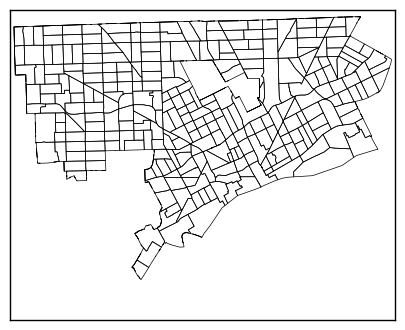

In [13]:
from mpl_toolkits.basemap import Basemap, cm
m = Basemap(
    projection='merc',
    lon_0=bds[0] + w / 2.,
    lat_0=bds[1] + h / 2.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - padding * w,
    llcrnrlat=coords[1] - .03,
    urcrnrlon=coords[2] + padding * w,
    urcrnrlat=coords[3] + .005,
    lat_ts=0,
    #resolution='l',
    suppress_ticks=True);

m.readshapefile(
    'shapefiles/detroit_census',
    'tracts');

In [14]:
from shapely.geometry import Point, Polygon

In [15]:
df_census = pd.DataFrame({
        'poly': [Polygon(xy) for xy in m.tracts],
        'tract_id': [tract['NAME10'] for tract in m.tracts_info]
        })

In [16]:
indexed_polys = zip(df_census['poly'].index.tolist(), df_census['poly'])
idx = rtree.index.Index()
for index, poly in indexed_polys:
    idx.insert(index, poly.bounds)

In [17]:
def find_intersecting_polys(polygons, poly_tree, a_map, coordinates):
    '''returns points within a polygon using rtree given:
       pd.Series of polygons, rtree index, Basemap object,
       and tuple of long,lat coordinates'''
    #convert points to map coordinates
    point = Point(a_map(coordinates[0], coordinates[1]))
    poly_idx = [poly_index for poly_index in poly_tree.intersection(point.coords[0])
                if point.within(polygons.ix[poly_index])]
    if poly_idx:
        return poly_idx[0]
    else:
        return np.nan

In [18]:
data['poly_idx'] = data['coordinates'].apply(
    lambda x: find_intersecting_polys(df_census['poly'], idx, m, x))

In [19]:
pds = data.groupby('poly_idx').count()

In [20]:
df_census = df_census.merge(pds,
                how='left',
                left_index=True,
                right_index=True
                ).fillna(0, downcast='infer')

In [21]:
df_census.drop_duplicates('tract_id', inplace=True)

In [22]:
kc = K_classifiers(df_census['coordinates'].values)

In [23]:
print(kc.best.name, kc.best.k)

Fisher_Jenks 6


In [24]:
#calculate Fisher-Jenks breaks for crime density
breaks = Fisher_Jenks(df_census['coordinates'].values,
                      k=kc.best.k)

df_census['bins'] = breaks.yb

In [25]:
breaks.bins

array([ 1,  4,  8, 13, 19, 30])

In [26]:
labels = ["<= %.2f (%s)" % (b, c) for b, c in zip(
    breaks.bins, breaks.counts)]

In [27]:
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard color ramp, and discretizes it,
    then draws a color bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in range(N + 1)]
    return LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

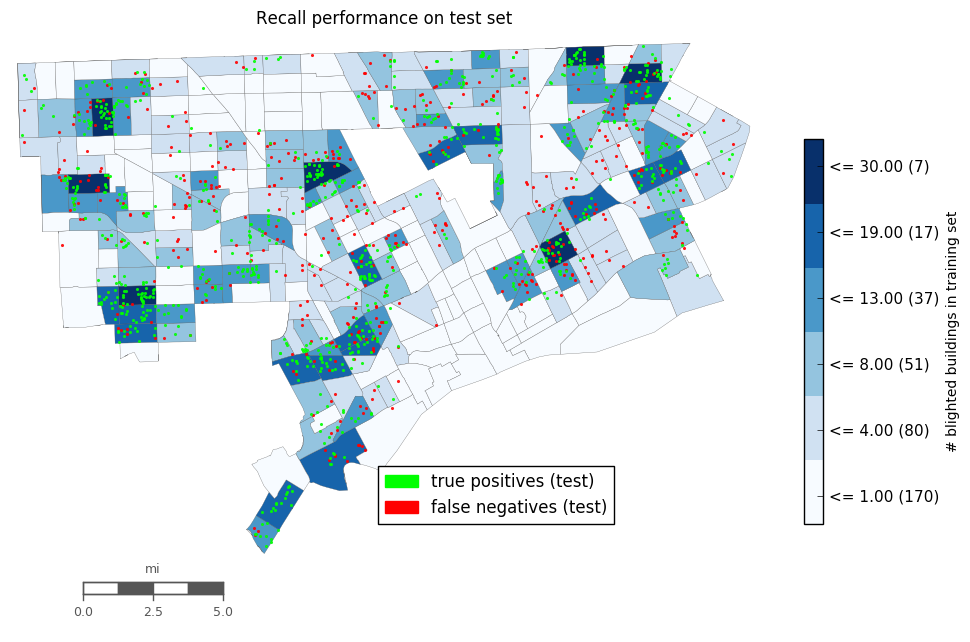

In [28]:
plt.clf()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# use a blue color ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')
# draw neighborhoods with grey outlines
df_census['patches'] = df_census['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))
pc = PatchCollection(df_census['patches'], match_original=True)
# impose our color map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_census['bins'].values)))
ax.add_collection(pc)

false_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(false_negatives['Longitude'], false_negatives['Latitude'])])

false = m.scatter(
    [geom.x for geom in false_points],
    [geom.y for geom in false_points],
    5, marker='o', lw=0,
    facecolor='#FF0000', edgecolor='w',
    alpha=0.9, antialiased=True,
    zorder=3);



true_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(true_pos['Longitude'], true_pos['Latitude'])])

false = m.scatter(
    [geom.x for geom in true_points],
    [geom.y for geom in true_points],
    5, marker='o', lw=0,
    facecolor='#00FF00', edgecolor='w',
    alpha=0.9, antialiased=True,
    zorder=3);

# Add a color bar
cb = colorbar_index(ncolors=len(labels), cmap=cmap, shrink=0.5, labels=labels, label='# blighted buildings in training set')
cb.ax.tick_params(labelsize=11)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.07, coords[1] - 0.013,
    coords[0], coords[1],
    length=5.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5,
    format='%1.1f',
    units='mi')

green = mpatches.Patch(color='#00FF00', label='true positives (test)')
red = mpatches.Patch(color='#FF0000', label='false negatives (test)')

plt.legend(handles=[green, red], bbox_to_anchor=(0.82, 0.29))

plt.title('Recall performance on test set', fontsize=12)
plt.tight_layout()
plt.savefig('recall_test.png', dpi=600, alpha=True)
plt.show()

In [29]:
df_census

,poly,tract_id,coordinates,prediction,is_blighted,bins,patches
0,"POLYGON ((15673.67123242743 33113.26084221434,...",1733,0,0,0,0,"Poly((15673.7, 33113.3) ...)"
1,"POLYGON ((16724.75300899705 33144.67681362852,...",1734,0,0,0,0,"Poly((16724.8, 33144.7) ...)"
3,"POLYGON ((18614.50089858135 33196.27047606278,...",1735,0,0,0,0,"Poly((18614.5, 33196.3) ...)"
5,"POLYGON ((19996.88770776059 33231.25951616, 19...",1736,0,0,0,0,"Poly((19996.9, 33231.3) ...)"
6,"POLYGON ((23193.42929889736 33282.08008752018,...",1752,0,0,0,0,"Poly((23193.4, 33282.1) ...)"
...,...,...,...,...,...,...,...
449,"POLYGON ((25365.97496730545 33297.9570506243, ...",2636,0,0,0,0,"Poly((25366, 33298) ...)"
450,"POLYGON ((27547.14207098429 33374.15327333752,...",2637,0,0,0,0,"Poly((27547.1, 33374.2) ...)"
453,"POLYGON ((29722.12304516734 33433.38816691469,...",2638,0,0,0,0,"Poly((29722.1, 33433.4) ...)"
455,"POLYGON ((31703.8092446513 33521.06390073337, ...",2640,0,0,0,0,"Poly((31703.8, 33521.1) ...)"


# Hexbin

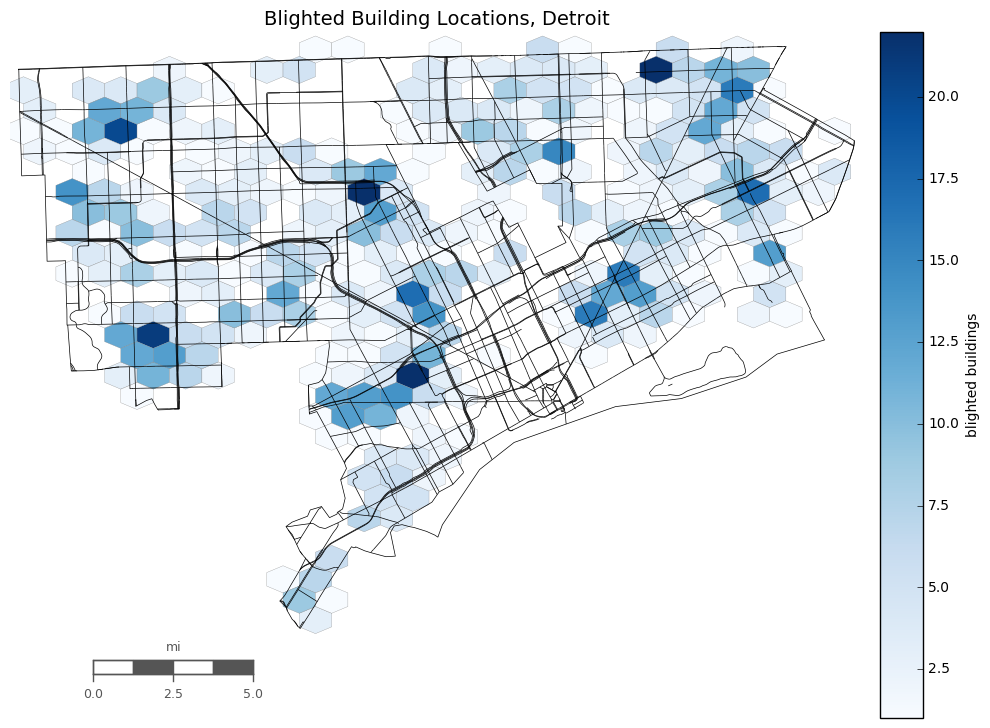

In [30]:
# set up plot
plt.clf()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)


m.readshapefile(
    'shapefiles/major-roads',
    'roads');

map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(df_positive_ex['Longitude'], df_positive_ex['Latitude'])])

# the mincnt argument only shows cells with a value >= 1
# hexbin wants np arrays, not plain lists
hx = m.hexbin(
    np.array([geom.x for geom in map_points]),
    np.array([geom.y for geom in map_points]),
    gridsize=25,
    #fbins='log',
    mincnt=1,
    edgecolor='gray',
    alpha=5,
    lw=0.2,
    cmap=plt.get_cmap('Blues'));

m.colorbar(location='right', format='%.1f', label='blighted buildings');

# draw a map scale
m.drawmapscale(
    coords[0] + 0.07, coords[1] - 0.013,
    coords[0], coords[1],
    length=5.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5,
    format='%1.1f',
    units='mi');

plt.title("Blighted Building Locations, Detroit", fontsize=14);
plt.tight_layout()
plt.savefig('blighted_buildings_hex_log.png', dpi=600, alpha=True)
plt.show()

# Scatter

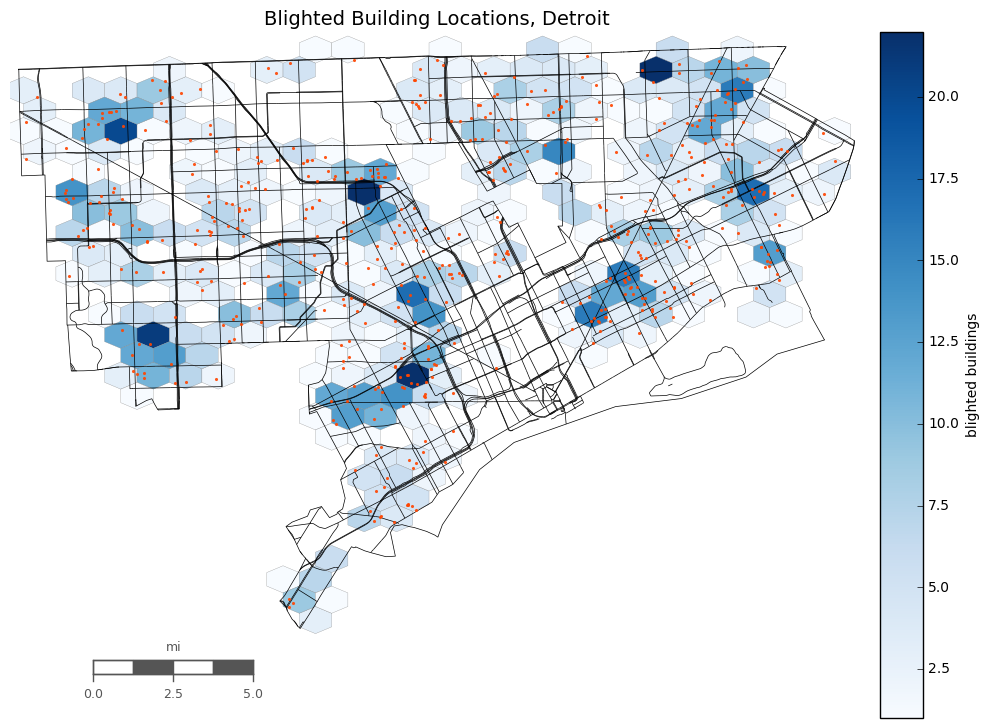

In [31]:
# set up plot
plt.clf()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)


m.readshapefile(
    'shapefiles/major-roads',
    'roads');

map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(df_positive_ex['Longitude'], df_positive_ex['Latitude'])])

scatter_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(false_negatives['Longitude'], false_negatives['Latitude'])])

sc = m.scatter(
    [geom.x for geom in scatter_points],
    [geom.y for geom in scatter_points],
    5, marker='o', lw=0,
    facecolor='#FF4500', edgecolor='w',
    alpha=0.9, antialiased=True,
    zorder=3);


# the mincnt argument only shows cells with a value >= 1
# hexbin wants np arrays, not plain lists
hx = m.hexbin(
    np.array([geom.x for geom in map_points]),
    np.array([geom.y for geom in map_points]),
    gridsize=25,
    #fbins='log',
    mincnt=1,
    edgecolor='gray',
    alpha=5,
    lw=0.2,
    cmap=plt.get_cmap('Blues'));

m.colorbar(location='right', format='%.1f', label='blighted buildings');

# draw a map scale
m.drawmapscale(
    coords[0] + 0.07, coords[1] - 0.013,
    coords[0], coords[1],
    length=5.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5,
    format='%1.1f',
    units='mi');

plt.title("Blighted Building Locations, Detroit", fontsize=14);
plt.tight_layout()
plt.savefig('blighted_buildings_hex_log.png', dpi=600, alpha=True)
plt.show()